In [32]:
import pandas as pd
import numpy as np
from pathlib import Path



In [33]:
path = Path('csv_out')
# 加载CSV文件
df = pd.read_csv(path/'tracking_data.csv')

# 按照车辆ID和时间排序
df.sort_values(by=['id', 'frame'], inplace=True)

In [34]:
df.head()

,frame,time,id,class,center_x,center_y,speed_kmh
0,1,0.034483,1,car,385,281,NaN
25,2,0.068966,1,car,385,281,NaN
49,3,0.103448,1,car,385,281,NaN
73,4,0.137931,1,car,385,281,NaN
97,5,0.172414,1,car,385,281,NaN


In [35]:
# 计算每个车辆在每个时间点的位移
df['delta_x'] = df.groupby('id')['center_x'].diff()
df['delta_y'] = df.groupby('id')['center_y'].diff()

# 计算每个点的方向角（弧度），范围为 [-π, π]
df['theta'] = np.arctan2(df['delta_y'], df['delta_x'])

In [36]:
# 计算方向角的变化量（角速度）
df['delta_theta'] = df.groupby('id')['theta'].diff()

# 为了处理角度跳变的问题，将变化量限制在 [-π, π] 范围内
df['delta_theta'] = (df['delta_theta'] + np.pi) % (2 * np.pi) - np.pi

# 填充缺失值
df['delta_theta'] = df['delta_theta'].fillna(0)

In [37]:
# 设置角度变化累积的窗口大小，例如3秒（假设帧率为30帧/秒）
window_size = 90  # 3秒 * 30帧/秒

# 对角度变化进行累积和
df['cum_delta_theta'] = df.groupby('id')['delta_theta'].rolling(window_size).sum().reset_index(level=0, drop=True)

In [57]:
# 设置窗口大小（可以根据需要调整）
window_size = 5

# 计算每个点的瞬时方向变化
df['delta_theta'] = df['theta'].diff().fillna(0)

# 使用滑动窗口来计算累积方向变化
df['windowed_delta_theta'] = df['delta_theta'].rolling(window=window_size, min_periods=1).sum()

# 设置阈值来判断转弯方向
turn_threshold = np.deg2rad(30)  # 30度的阈值

# 初始化转弯标签
df['turn_label'] = 'Forward'  # 默认为直行

# 判断左转
df.loc[df['windowed_delta_theta'] > turn_threshold, 'turn_label'] = 'Turn Left'

# 判断右转
df.loc[df['windowed_delta_theta'] < -turn_threshold, 'turn_label'] = 'Turn Right'

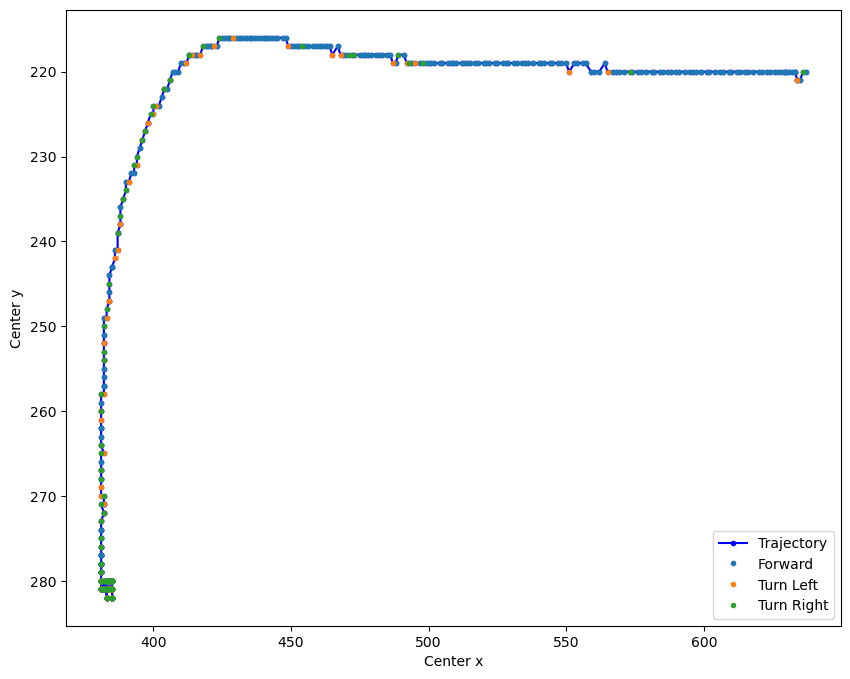

In [58]:
import matplotlib.pyplot as plt

# 选择一个车辆轨迹进行可视化
vehicle_id = df['id'].unique()[0]  # 选择第一个车辆ID
vehicle_df = df[df['id'] == vehicle_id]

plt.figure(figsize=(10, 8))
plt.plot(vehicle_df['center_x'], vehicle_df['center_y'], 'b.-', label='Trajectory')

# 根据转弯标签改变颜色
for label, group in vehicle_df.groupby('turn_label'):
    plt.plot(group['center_x'], group['center_y'], '.', label=label)

plt.gca().invert_yaxis()  # 反转 y 轴以匹配 OpenCV 的坐标系
plt.legend()
plt.xlabel('Center x')
plt.ylabel('Center y')
# plt.title(f'vehicle {vehicle_id} trajectory and turning label at each frame')

plt.savefig(f'vehicle_{vehicle_id}_trajectory_and_turning_label_at_each_frame.png', dpi=300)
plt.show()

In [59]:
# 首先，确保数据框按照车辆 ID 和时间排序
df.sort_values(by=['id', 'frame'], inplace=True)

# 对于每个车辆 ID，统计其转弯标签的出现次数
turn_label_counts = df.groupby('id')['turn_label'].value_counts().unstack(fill_value=0)

In [60]:
import numpy as np

# 计算每一步的方向变化
df['delta_theta'] = np.arctan2(df['center_y'].diff(), df['center_x'].diff()).fillna(0)

# 对每个车辆的方向变化进行累积求和
df['cum_delta_theta'] = df.groupby('id')['delta_theta'].cumsum()

# 为每个车辆分配总体转弯标签
def assign_overall_turn_label(row):
    # 获取该车辆的累计转向角度变化
    total_delta_theta = row['cum_delta_theta']

    # 设置一个全局阈值来判断是否是一个明显的转弯行为
    overall_threshold = np.deg2rad(45)  # 45度的阈值，可以根据需要调整

    # 判断转弯方向
    if total_delta_theta > overall_threshold:
        return 'left_turn'
    elif total_delta_theta < -overall_threshold:
        return 'right_turn'
    else:
        return 'straight'

# 直接在 df 上应用函数，添加整体转弯标签列
df['overall_turn_label'] = df.apply(assign_overall_turn_label, axis=1)

In [61]:
df.head()

,frame,time,id,class,center_x,center_y,speed_kmh,delta_x,delta_y,theta,delta_theta,cum_delta_theta,windowed_delta_theta,turn_label,overall_turn_label
0,1,0.034483,1,car,385,281,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Forward,straight
25,2,0.068966,1,car,385,281,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Forward,straight
49,3,0.103448,1,car,385,281,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Forward,straight
73,4,0.137931,1,car,385,281,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Forward,straight
97,5,0.172414,1,car,385,281,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Forward,straight


In [62]:
# 重置索引，准备合并
turn_label_counts_reset = turn_label_counts[['overall_turn_label']].reset_index()

# 将总体转弯标签合并到原始数据框
df = pd.merge(df, turn_label_counts_reset[['id', 'overall_turn_label']], on='id', how='left')

KeyError: "None of [Index(['overall_turn_label'], dtype='object', name='turn_label')] are in the [columns]"

In [63]:
df.head()

,frame,time,id,class,center_x,center_y,speed_kmh,delta_x,delta_y,theta,delta_theta,cum_delta_theta,windowed_delta_theta,turn_label,overall_turn_label
0,1,0.034483,1,car,385,281,NaN,NaN,NaN,NaN,0.0,0.0,0.0,Forward,straight
25,2,0.068966,1,car,385,281,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Forward,straight
49,3,0.103448,1,car,385,281,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Forward,straight
73,4,0.137931,1,car,385,281,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Forward,straight
97,5,0.172414,1,car,385,281,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Forward,straight


In [64]:
# left turn id
df[df['overall_turn_label']=='left_turn']['id'].unique()

array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        16,  17,  19,  20,  22,  24,  26,  27,  28,  29,  30,  33,  34,
        35,  36,  37,  38,  39,  40,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  60,  61,  64,  70,  73,
        74,  77,  78,  79,  82,  83,  84,  87,  88,  90,  91,  92,  93,
        94,  95,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 110, 111, 113, 115, 116, 117, 118, 119, 122, 125, 127, 128,
       131, 133, 134, 135, 136, 138, 139, 145, 146, 151, 152, 154, 155,
       157, 161, 162, 163, 169, 170, 172, 173, 174, 175, 176, 177, 180,
       181, 182, 184, 185, 186, 189, 190, 191, 193, 197, 198, 199, 200,
       201, 202, 204, 205, 206, 207, 208, 210, 212, 213, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       232, 234, 235, 237, 238, 239, 240, 241, 242, 249, 253, 254, 255,
       256, 257, 258, 259, 260, 263, 270, 273, 274, 275, 276, 27

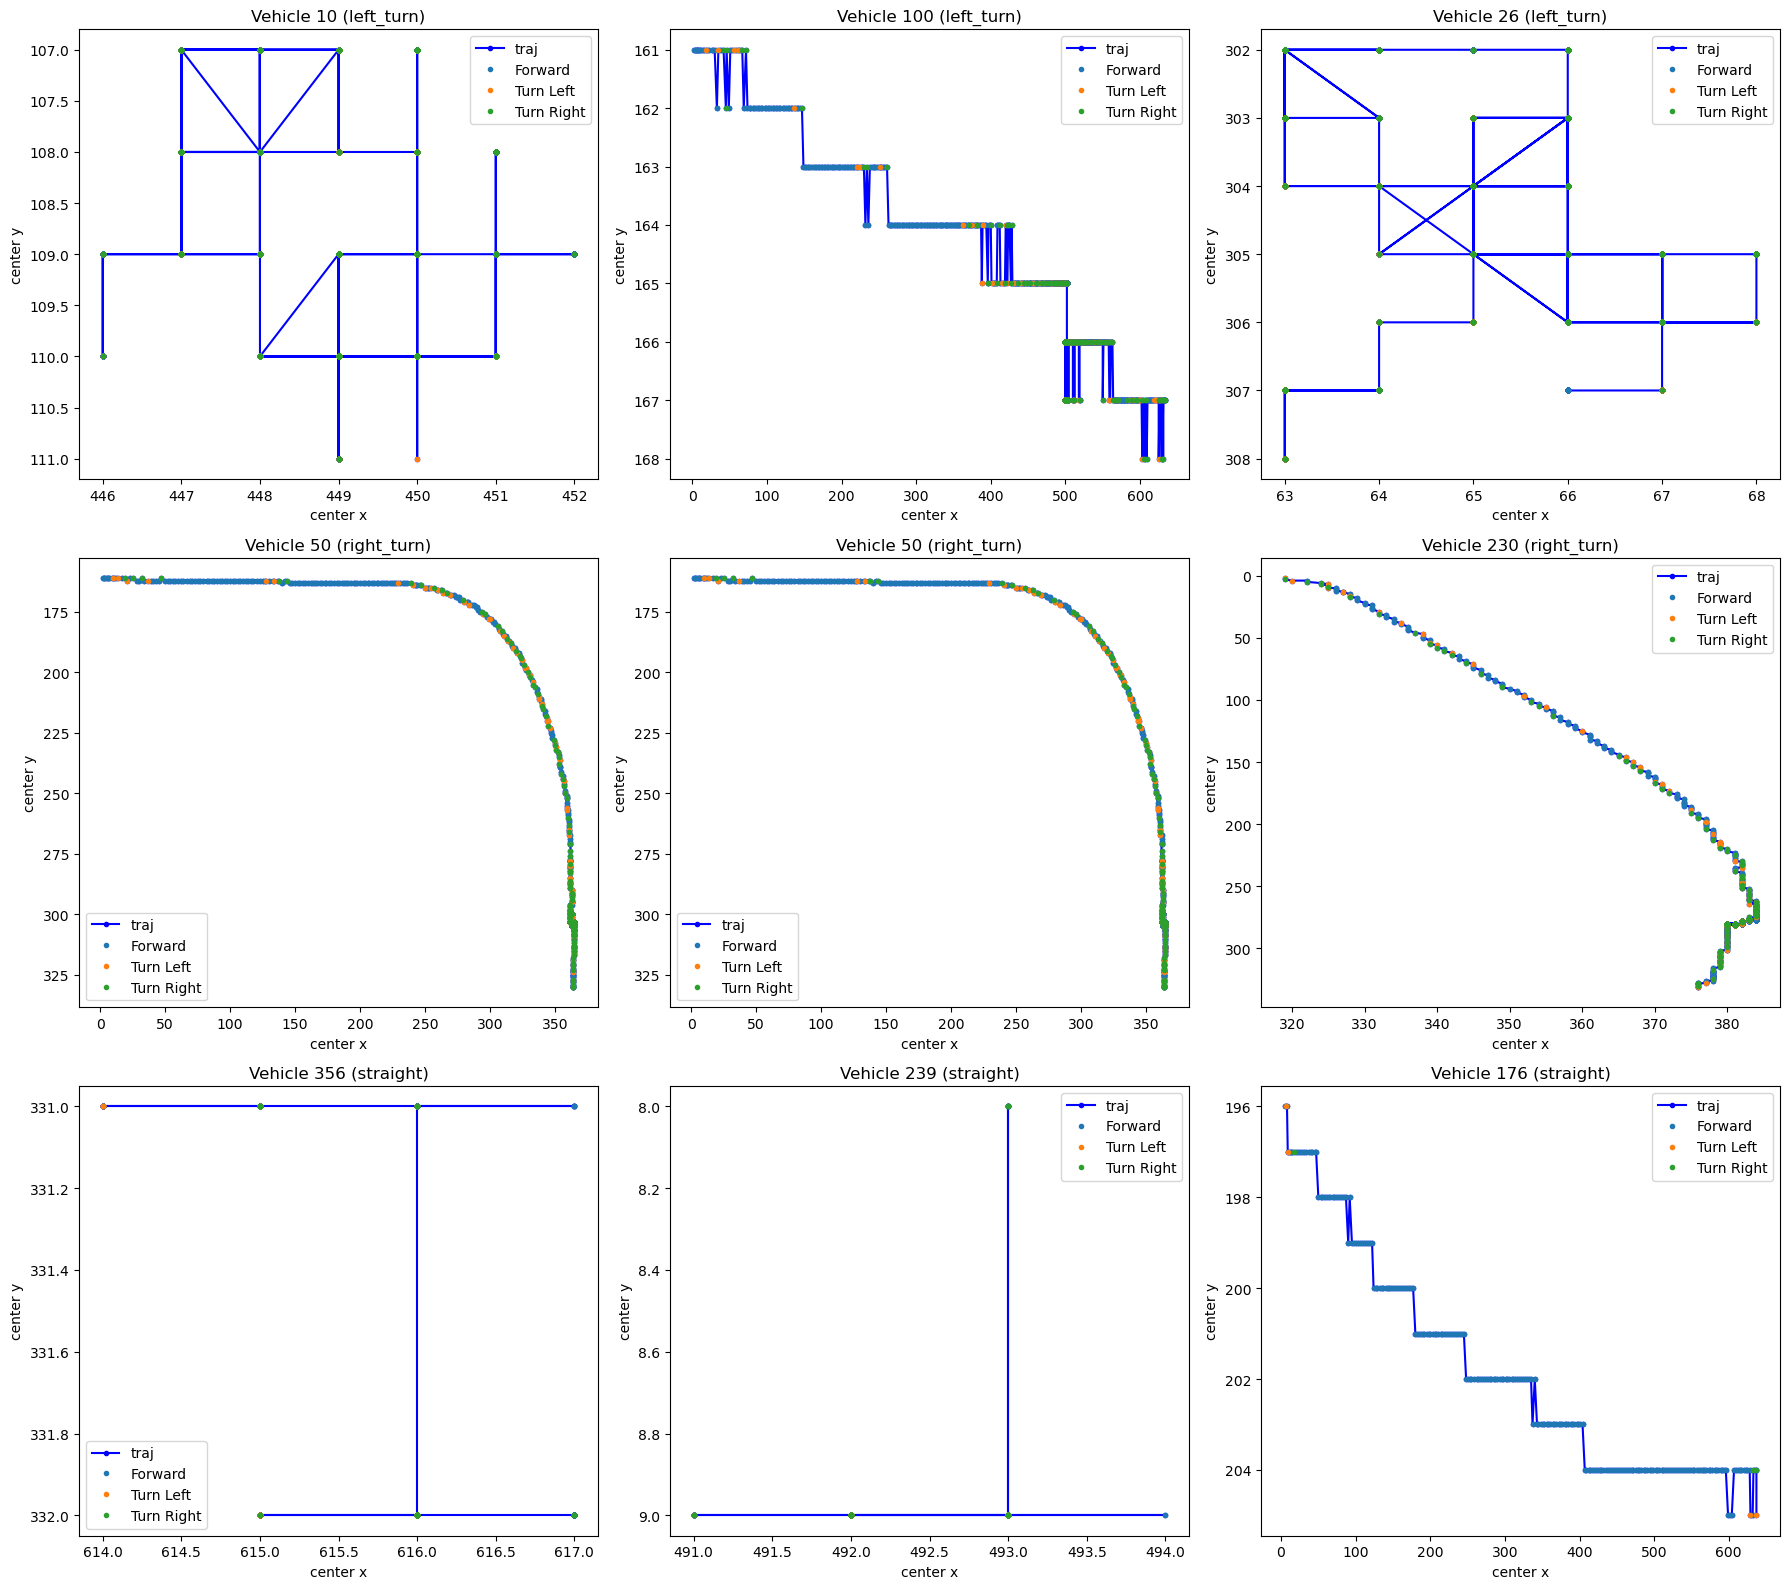

In [65]:
import matplotlib.pyplot as plt

# 定义需要可视化的转弯类型
turn_types = ['left_turn', 'right_turn', 'straight']

# 创建 3x3 的子图
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

# 遍历每种转弯类型
for i, turn_type in enumerate(turn_types):
    # 随机选择三个对应转弯类型的车辆ID
    sampled_vehicle_ids = df[df['overall_turn_label'] == turn_type]['id'].sample(3, replace=False).values
    
    # 遍历这三个车辆ID
    for j, vehicle_id in enumerate(sampled_vehicle_ids):
        # 提取该车辆的轨迹数据
        vehicle_df = df[df['id'] == vehicle_id]
        
        # 绘制轨迹
        ax = axes[i, j]
        ax.plot(vehicle_df['center_x'], vehicle_df['center_y'], 'b.-', label='traj')

        # 根据转弯标签改变颜色
        for label, group in vehicle_df.groupby('turn_label'):
            ax.plot(group['center_x'], group['center_y'], '.', label=label)
        
        ax.invert_yaxis()  # 反转 y 轴以匹配 OpenCV 的坐标系
        ax.set_title(f'Vehicle {vehicle_id} ({turn_type})')
        ax.set_xlabel('center x')
        ax.set_ylabel('center y')
        ax.legend()

plt.tight_layout()
plt.show()

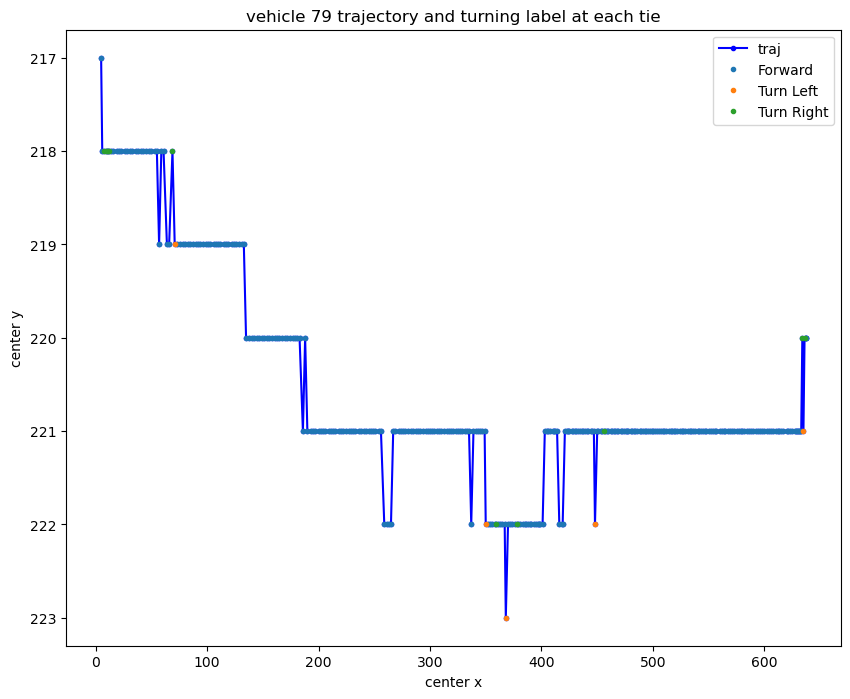

In [66]:
import matplotlib.pyplot as plt

# 选择一个车辆轨迹进行可视化
vehicle_id = np.random.choice(df[df['overall_turn_label'] == 'left_turn']['id'].unique())
vehicle_df = df[df['id'] == vehicle_id]

plt.figure(figsize=(10, 8))
plt.plot(vehicle_df['center_x'], vehicle_df['center_y'], 'b.-', label='traj')

# 根据转弯标签改变颜色
for label, group in vehicle_df.groupby('turn_label'):
    plt.plot(group['center_x'], group['center_y'], '.', label=label)

plt.gca().invert_yaxis()  # 反转 y 轴以匹配 OpenCV 的坐标系
plt.legend()
plt.xlabel('center x')
plt.ylabel('center y')
plt.title(f'vehicle {vehicle_id} trajectory and turning label at each tie')
plt.show()

In [67]:
df[df['overall_turn_label'] == 'left_turn']['id'].unique()

array([  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        16,  17,  19,  20,  22,  24,  26,  27,  28,  29,  30,  33,  34,
        35,  36,  37,  38,  39,  40,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  60,  61,  64,  70,  73,
        74,  77,  78,  79,  82,  83,  84,  87,  88,  90,  91,  92,  93,
        94,  95,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 110, 111, 113, 115, 116, 117, 118, 119, 122, 125, 127, 128,
       131, 133, 134, 135, 136, 138, 139, 145, 146, 151, 152, 154, 155,
       157, 161, 162, 163, 169, 170, 172, 173, 174, 175, 176, 177, 180,
       181, 182, 184, 185, 186, 189, 190, 191, 193, 197, 198, 199, 200,
       201, 202, 204, 205, 206, 207, 208, 210, 212, 213, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       232, 234, 235, 237, 238, 239, 240, 241, 242, 249, 253, 254, 255,
       256, 257, 258, 259, 260, 263, 270, 273, 274, 275, 276, 27

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 定义颜色映射
label_color_map = {
    'left_turn': 'red',
    'right_turn': 'blue',
    'straight': 'green',
    'unknown': 'gray'  # 如果有未确定的标签
}

/home/xingnan/anaconda3/envs/drone_detection/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36710 (\N{CJK UNIFIED IDEOGRAPH-8F66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xingnan/anaconda3/envs/drone_detection/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36742 (\N{CJK UNIFIED IDEOGRAPH-8F86}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xingnan/anaconda3/envs/drone_detection/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDEOGRAPH-8F68}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xingnan/anaconda3/envs/drone_detection/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36857 (\N{CJK UNIFIED IDEOGRAPH-8FF9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xingnan/anaconda3/envs/drone_detection/lib/python3.10/site-pac

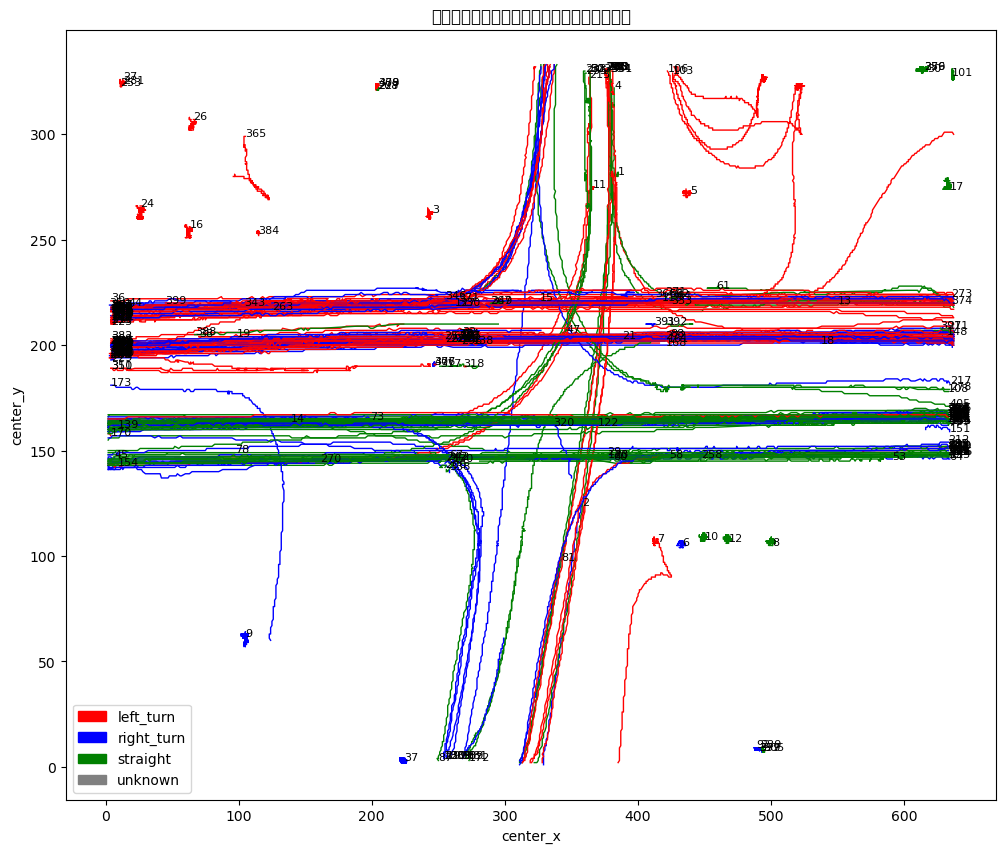

In [69]:
# 获取所有的车辆ID
vehicle_ids = df['id'].unique()

plt.figure(figsize=(12, 10))


df_left = df[df['overall_turn_label'] == 'left_turn']

# 遍历每个车辆ID
for vehicle_id in vehicle_ids:
    vehicle_df = df[df['id'] == vehicle_id]
    overall_label = vehicle_df['overall_turn_label'].iloc[0]  # 获取总体转弯标签
    color = label_color_map.get(overall_label, 'black')  # 获取对应的颜色
    
    # 绘制车辆轨迹
    plt.plot(vehicle_df['center_x'], vehicle_df['center_y'], color=color, linewidth=1)
    
    # 可选：在轨迹的起点标注车辆ID
    plt.text(vehicle_df['center_x'].iloc[0], vehicle_df['center_y'].iloc[0], str(vehicle_id), fontsize=8)

# 创建图例
handles = [mpatches.Patch(color=color, label=label) for label, color in label_color_map.items()]
plt.legend(handles=handles)

plt.xlabel('center_x')
plt.ylabel('center_y')
plt.title('车辆轨迹（根据总体转弯标签进行颜色编码）')
plt.show()

In [70]:
df['overall_turn_label'].unique()

array(['straight', 'left_turn', 'right_turn'], dtype=object)

TypeError: imshow() missing 1 required positional argument: 'X'

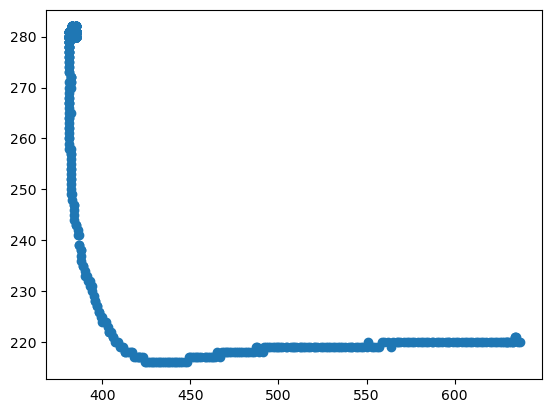

In [71]:
plt.scatter(df[df['id']==1].center_x, df[df['id']==1].center_y)
plt.imshow()
plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 读取视频的第一帧
video_path = 'one_video/DJI_0007.mp4'  # 将 'your_video.mp4' 替换为你的实际文件名
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if ret:
    # 将 BGR 图像转换为 RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # 在 Matplotlib 中显示图像
    plt.imshow(frame_rgb)
    
    # 绘制 scatter plot 叠加在图像上
    plt.scatter(df[df['id'] == 1]['center_x'], df[df['id'] == 1]['center_y'], color='pink', s=0.5)
    
    
    plt.axis('off')  # 如果你不想显示坐标轴
    plt.show()
else:
    print("无法读取视频帧，请检查路径。")

In [72]:
df[df['id'] == 1]['overall_turn_label'].unique()

array(['straight', 'left_turn', 'right_turn'], dtype=object)

In [73]:
# 独热编码
overall_turn_dummies = pd.get_dummies(df['overall_turn_label'], prefix='overall_turn')

# 将独热编码的特征添加到数据框
df = pd.concat([df, overall_turn_dummies], axis=1)

In [74]:
# 假设原始的输入特征为 'center_x', 'center_y', 'speed_kmh' 等
input_features = ['center_x', 'center_y', 'speed_kmh']  # 根据实际情况调整

# 将新的总体转弯特征加入到输入特征列表中
overall_turn_features = [col for col in df.columns if col.startswith('overall_turn_')]
input_features.extend(overall_turn_features)

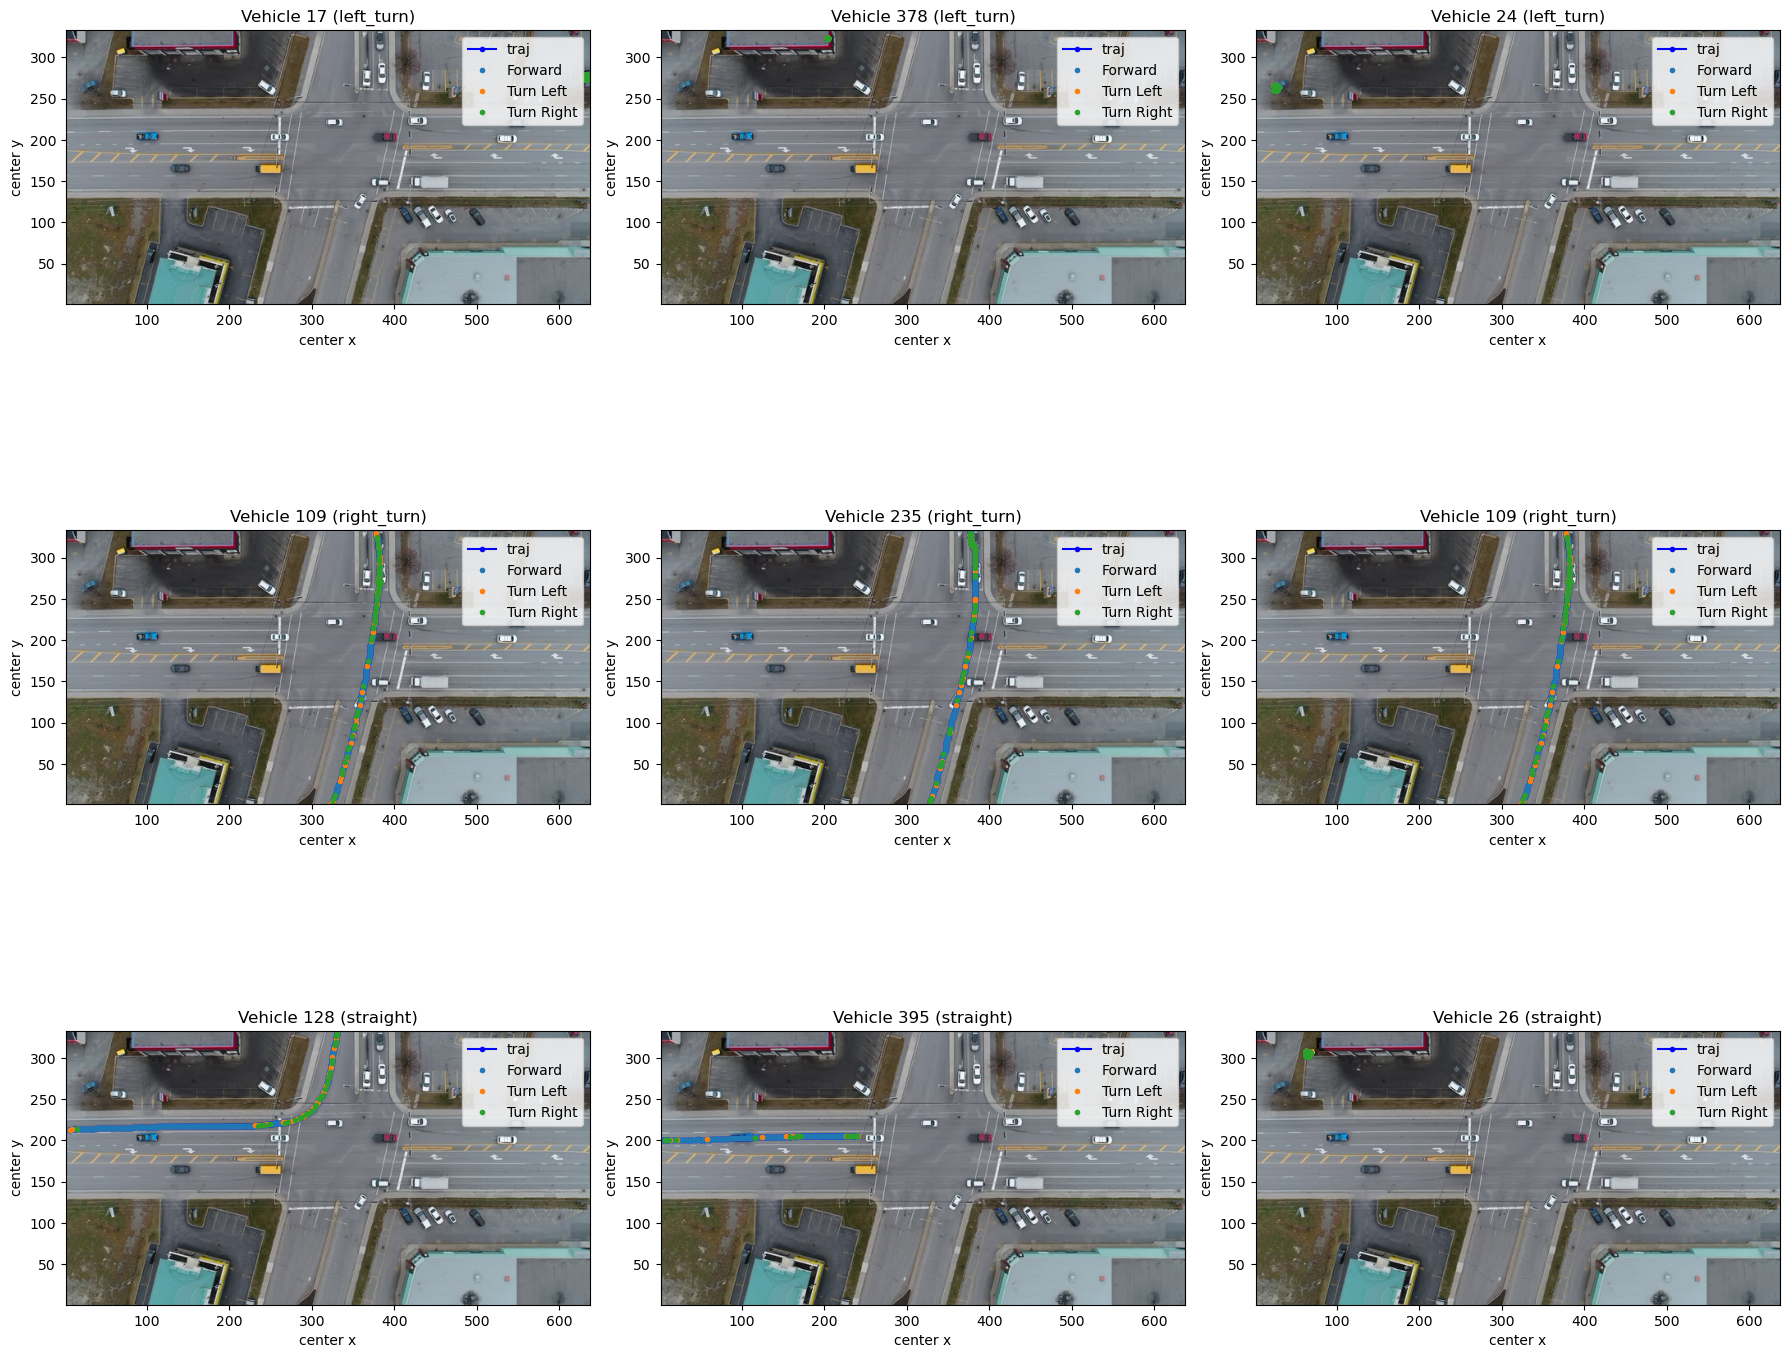

In [75]:
import cv2
import matplotlib.pyplot as plt

# 读取视频的第一帧
video_path = 'one_video/DJI_0007.mp4'  # 确保路径正确
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

if not ret:
    print("无法读取视频帧，请检查路径。")
else:
    # 将 BGR 图像转换为 RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 定义需要可视化的转弯类型
    turn_types = ['left_turn', 'right_turn', 'straight']

    # 创建 3x3 的子图
    fig, axes = plt.subplots(3, 3, figsize=(18, 16))

    # 遍历每种转弯类型
    for i, turn_type in enumerate(turn_types):
        # 随机选择三个对应转弯类型的车辆ID
        sampled_vehicle_ids = df[df['overall_turn_label'] == turn_type]['id'].sample(3, replace=False).values

        # 遍历这三个车辆ID
        for j, vehicle_id in enumerate(sampled_vehicle_ids):
            # 提取该车辆的轨迹数据
            vehicle_df = df[df['id'] == vehicle_id]

            # 获取当前的子图
            ax = axes[i, j]

            # 显示原始视频帧
            ax.imshow(frame_rgb, extent=[df['center_x'].min(), df['center_x'].max(), df['center_y'].max(), df['center_y'].min()])

            # 在原始视频帧上叠加轨迹
            ax.plot(vehicle_df['center_x'], vehicle_df['center_y'], 'b.-', label='traj')

            # 根据转弯标签改变颜色
            for label, group in vehicle_df.groupby('turn_label'):
                ax.plot(group['center_x'], group['center_y'], '.', label=label)

            ax.set_title(f'Vehicle {vehicle_id} ({turn_type})')
            ax.set_xlabel('center x')
            ax.set_ylabel('center y')
            ax.legend()
            ax.invert_yaxis()  # 反转 y 轴以匹配 OpenCV 的坐标系

    plt.tight_layout()
    plt.show()

In [76]:
# left 50 , right 315